In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
# from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm

### Задача 1. CUPED (2.5 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [6]:
control_before = stats.expon(scale=1000).rvs(1000)

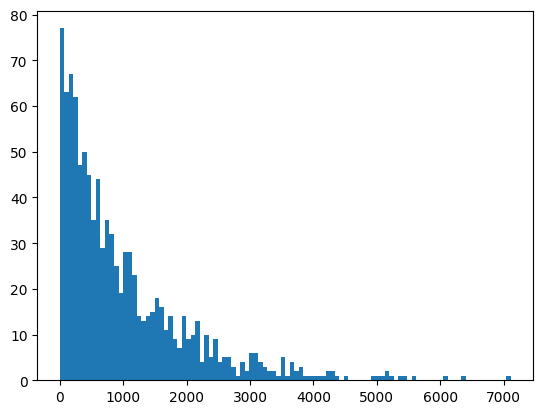

In [7]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [8]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

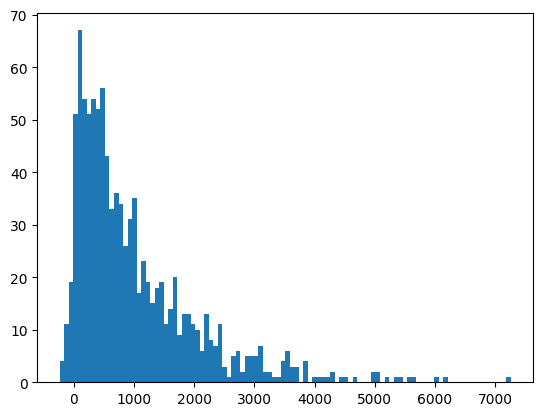

In [9]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [10]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 941.47102065, 1070.82819665])

In [11]:
bad_cnt = 0

N = 10000
for i in range(N):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

Стат значимая разница есть в 4.83% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [12]:
bad_cnt = 0

N = 10000
for i in range(N):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    theta = (np.cov(control_before, control) / np.var(control_before))[1, 0]
    control_cuped = control - theta * control_before + theta * control_before.mean()
    mean = control_cuped.mean()
    std = control_cuped.std() / np.sqrt(len(control_cuped))
                                        
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

Стат значимая разница есть в  84.45% случаев;


In [13]:
std

3.1346765137369905

Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [14]:
def calc_theta(a, b, a_before, b_before):
    y = np.hstack([a, b])
    y_before = np.hstack([a_before, b_before])
    return np.cov(y_before, y)[0, 1] / y_before.var()


bad_cnt = 0
ttest_cnt = 0

N = 10000
for i in range(N):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(samples_in_ab // 2)
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(samples_in_ab // 2)

    theta_2 = calc_theta(control_after_a, control_after_b, control_before_a, control_before_b)

    control_cup_a = control_after_a - theta_2 * (control_before_a - control_before_full.mean())
    control_cup_b = control_after_b - theta_2 * (control_before_b - control_before_full.mean())

    # control_cup_a = control_after_a - theta_2 * (control_before_a)
    # control_cup_b = control_after_b - theta_2 * (control_before_b)

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1

    ttest_cnt += int(stats.ttest_ind(control_cup_a, control_cup_b).pvalue < 0.05)

print(f"Стат значимая разница есть в  {(round(bad_cnt / N, 4) * 100):.4f}% случаев;")

Стат значимая разница есть в  4.9100% случаев;


In [15]:
ttest_cnt / N * 100

5.04

Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:

В первом случае применения CUPED фактически сделали регрессию переменной самой на себя, что в целом пожалуй не очень корректно, тк $Var(Y_{cuped}) = Var(Y) * (1 - \rho) \approx 0 $ и ну как бы да (не ноль за счет наличия некоторого независимого нормального $\epsilon$). С околонулевой дисперсией любое отклонения от нуля будет казаться нам стат значимым 

А далее мы считаем $\theta$ на всей доступной выборке (на двух группах, с эффектом или без). То есть уже немного лучше, дисперсия уменьшается в подвыборках именно за счет корреляции приближенного исходного распределения и зашумленных значений. И соответственно мы "убираем" информацию об исходном распределении, и, в сущности, сравниваем два нормальных шума с одинаковыми параметрами. И логично получаем стат значимую разницу на уровне ошибки первого рода. 


Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [16]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in range(N):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    mean_3 = control_before_full.mean()

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )

    theta_3 = calc_theta(control_after_a, control_after_b, control_before_a, control_before_b)
    
    control_cup_a = control_after_a - theta_3 * (control_before_a - mean_3)
    control_cup_b = control_after_b - theta_3 * (control_before_b - mean_3)

    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100:.2f}% случаев; при использовании CUPED -- в {(round(bad_cnt_cuped / N, 4) * 100):.2f}% случаев"
)

Стат значимая разница есть в  6.10% случаев; при использовании CUPED -- в 47.10% случаев


### Задача 2. Методы снижения дисперсии (2.5 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: 
- `None` - пользователь не участвует в АБ тесте, 
- `*_before_i` - соответствующая группа до начала теста, 
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение. 

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Задание
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED. 

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [206]:
from scipy.stats import t

def ttest(a, b, alpha = 0.05, H_a='two-sided', print_res=False):
    """проверяет H_0: mu_a - mu_b = 0"""
    n1, n2 = a.shape[0], b.shape[0]
    s1, s2 = a.std(), b.std()
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    d_f = s**4 / ((s1**2/n1)**2/(n1 - 1) + (s2**2/n2)**2/(n2 - 1))
    T_obs = (a.mean() - b.mean()) / s
    if H_a == 'two-sided': 
        l, r = t(df=d_f).ppf([0.025, 0.975])
        p_value = min(2 * t.cdf(T_obs, d_f), 2 * (1 - t.cdf(T_obs, d_f)))
        if print_res == True:
            # print(f'T_observed: {round(T_obs, 3)}, s_observed: {round(s, 3)}')
            if T_obs < l or T_obs > r:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)
     #H_a: mu_a - mu_b > 0
    elif H_a == 'right':
        p_value = 1 - t(df=d_f).cdf(T_obs)
        if print_res:
            if p_value > alpha:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)
    #H_a: mu_a - mu_b < 0
    elif H_a == 'left':
        p_value = t(df=d_f).cdf(T_obs)
        if print_res:
            if p_value > alpha:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)

In [20]:
data = pd.read_csv("data_ab.csv")

Размеры групп для тестирования одинаковые, поэтому можем привести данные в чуть более удобный вид

In [49]:
group_list = ['control_before','treatment_before', 'control_after_1',
               'treatment_after_1', 'control_after_2', 'treatment_after_2',
               'control_after_3', 'treatment_after_3', 'control_after_4',
               'treatment_after_4', 'control_after_5', 'treatment_after_5']

def transform_data(data, age_list = ['young', 'adult', 'old'], group_list=group_list):
    for a in age_list:
        df = pd.DataFrame()
        df.loc[:, 'age'] = (
            data.loc[(data.age == a) & (data.group == 'treatment_after_1')]
            .age.reset_index(drop=True)
        )
        for g in group_list:
            df.loc[:, g] = data.loc[(data.age == a) & (data.group == g)].reset_index(drop=True).metric
        yield df

In [50]:
df = pd.concat(transform_data(data), axis=0)

df.head(2)

,age,control_before,treatment_before,control_after_1,treatment_after_1,control_after_2,treatment_after_2,control_after_3,treatment_after_3,control_after_4,treatment_after_4,control_after_5,treatment_after_5
0,young,8496.554679,11309.036916,8741.374306,11001.898483,9113.675629,10963.358305,8953.734508,10951.917020,9030.087523,11044.747851,9109.208016,11086.638630
1,young,11891.862586,9229.445011,11818.071476,9312.880516,12178.351619,9656.437561,12299.423731,9722.345791,12407.289137,9673.505484,12228.813543,10073.284614


In [156]:
ttest(df.control_before, df.treatment_before)

(0.9642001147497369, True)

#### Post-strat

In [143]:
# считаем веса на всех уникальных юзерах
weights = (
    data[data.group.isin(['treatment_before', 'control_before']) | data.group.isnull()]
    .age.value_counts(normalize=True, sort=False)
)

In [151]:
def calculate_weighted_stats(df: pd.DataFrame, weights: pd.Series, cat_column='age'):
    """
    args:
        df (pd.DataFrame): 
            cat_column (str) - category for aggregation
            <amount> (float) - value to calculate mean and std
        weights (pd.Series):
            weights.index (str) - category
            weights.values (float) - weight of a category
        cat_column (str): name of a category
    return:
        (mean, std)
    """
    grouped = df.groupby(cat_column).agg(['mean', 'std'])
    grouped.columns = ['mean_est', 'std_est']
    grouped.loc[:, 'weight'] = grouped.index.map(weights)

    return (
        (grouped.mean_est * grouped.weight).sum(),
        (grouped.std_est * grouped.weight).sum(),
    )

In [155]:
calculate_weighted_stats(df.iloc[:, :2], weights)

(11533.27212545056, 1268.8579675172152)

In [202]:
def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series,
                cat_column: str ='age', alpha = 0.05, print_res=False,):
    """
    args:
        a (pd.DataFrame): 
            cat_column (str) - category for aggregation
            <amount> (float) - value to test avg
        b (pd.DataFrame) - same as a
        
        weights (pd.Series):
            weights.index (str) - category
            weights.values (float) - weight of a category
        cat_column (str): name of a category
    return:
        (p-value, res)
    """
    n1 = len(a)
    n2 = len(b)

    a_mean, s1 = calculate_weighted_stats(a, weights, cat_column)
    b_mean, s2 = calculate_weighted_stats(b, weights, cat_column)

    # реализую только двусторонний
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    d_f = s**4 / ((s1**2/n1)**2/(n1 - 1) + (s2**2/n2)**2/(n2 - 1))
    T_obs = (a_mean - b_mean) / s
    l, r = t(df=d_f).ppf([alpha / 2, (1 - alpha) / 2])
    p_value = min(2 * t.cdf(T_obs, d_f), 2 * (1 - t.cdf(T_obs, d_f)))

    decision = 'regect H_0' if T_obs < l or T_obs > r else 'accept H_0'
    if print_res == True:
        print(f'T_obs: {round(T_obs, 3):.3f}, s_obs: {round(s, 3):.3f}, p-value {round(p_value, 3):.3f}, {decision}')
    return round(p_value, 4), (p_value > alpha)

#### CUPED

выбираем в качестве ковариаты прошлые значения метрики по юзерам из обеих групп.~~выбираем как и положено из множества доступных вариантов~~

In [551]:
def ttest_cuped(a: np.array, b: np.array, a_before: np.array, b_before: np.array,
                mu: float, alpha = 0.05, print_res=False):
    """
    a - for control group
    b - for treatment
    mu - mean by full available data 
    """
    n1, n2 = len(a), len(b)
    theta = calc_theta(a, b, a_before, b_before)
    # print(theta)
    a_cuped = a - theta * a_before + theta * mu
    b_cuped = b - theta * b_before + theta * mu

    res = ttest(a_cuped, b_cuped, alpha=alpha)
    print(f'pvalue={round(res[0], 3)},', 'H0 rejected' if res[0] else 'H0 accepted')

    # return 

#### Проверяем

In [208]:
for i in range(1, 6):

    ttest(
        df[f'control_after_{i}'].to_numpy(),
        df[f'treatment_after_{i}'].to_numpy(),
        print_res=True
    )

accept H_0, p-value = 0.692
accept H_0, p-value = 0.403
accept H_0, p-value = 0.234
accept H_0, p-value = 0.121
accept H_0, p-value = 0.054


In [177]:
MU = data[data.group.isin(['treatment_before', 'control_before']) | data.group.isnull()].metric.mean()

In [214]:
for i in range(1, 6):

    ttest_strat(
        df[['age', f'control_after_{i}']],
        df[['age', f'treatment_after_{i}']],
        weights=weights,
        cat_column='age',
        print_res=True
    )

T_obs: -1.163, s_obs: 27.018, p-value 0.245, accept H_0
T_obs: -2.307, s_obs: 27.478, p-value 0.021, regect H_0
T_obs: -3.191, s_obs: 27.895, p-value 0.001, regect H_0
T_obs: -4.053, s_obs: 28.368, p-value 0.000, regect H_0
T_obs: -4.982, s_obs: 28.759, p-value 0.000, regect H_0


In [210]:
for i in range(1, 6):

    ttest_cuped(
        df[f'control_after_{i}'].to_numpy(),
        df[f'treatment_after_{i}'].to_numpy(),
        df['control_before'].to_numpy(),
        df['treatment_before'].to_numpy(),
        MU, 
        print_res=True
    )

pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected


1. При обычном тестировании мы бы не получили на первых двух итерациях результатов в принципе, а далее наши выводы будут довольно чувствительны к выбору уровня значимости 
2. Стратификация уже на второй итерации дает стат. значимый результат 
3. А CUPED совсем жестко уменьшает дисперсию, получаем стат значимые результаты для любого разумного уровня значимости

Так что в нашем небольшом соревновании победил cuped, но что и несильно удивительно, учитывая уровень связи "выбранной" ковариаты

### Задача 3. Линеаризация + CUPED (2 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.


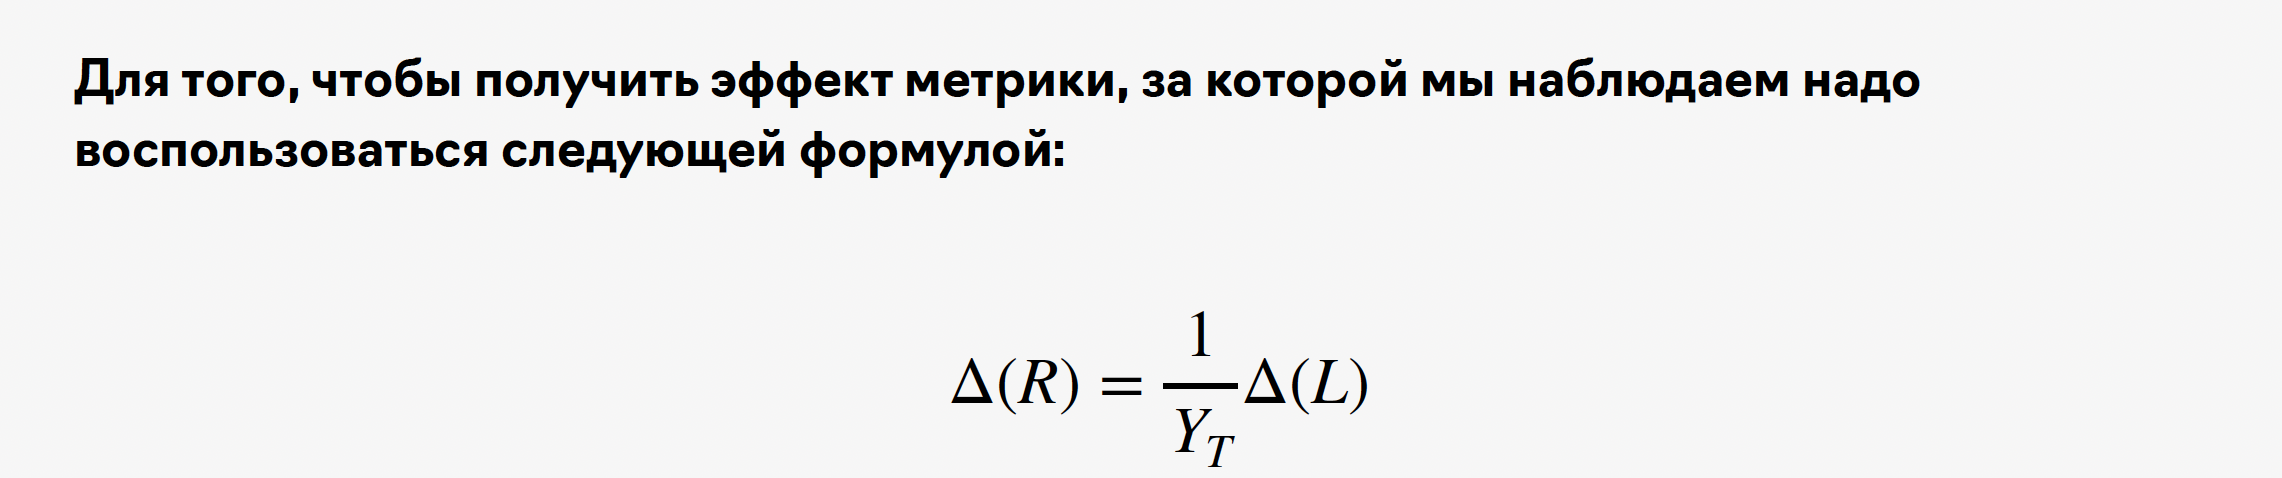

Используем некоторые функции с семинаров

In [450]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)

    # для эффекта по формуле с лекции, god bless записи и гит с презами
    Y_T = np.sum(b_y) / len(b_y)
    return pvalue, delta / Y_T # effect


def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

In [218]:
d_aa = pd.read_csv('duration_aa.csv').drop(columns='Unnamed: 0')

Для линеаризации нужно сгруппировать по юзерам:

In [222]:
agg_d_aa = d_aa.groupby(['group', 'user_id']).visit_duration.apply(list)

Проведем одиночный тест, тут на адекватных УЗ нулевая не отвергается

In [235]:
print(f"pvalue = {check_linearization(agg_d_aa['first'], agg_d_aa['second'])[0]:.2f}")

pvalue = 0.44


Построим распределение ПИВАлью с помощью бутстрапа 

Сэмплируем как и положено по юзерам

In [446]:
def run_bs_lin_test(a: pd.Series, b: pd.Series, N_ITER=1000, replace=False, size=100):

    pvalue_list = []
    effect_list = []
    effect_lin_list = []

    for _ in tqdm(range(N_ITER)):
        n_a = a.shape[0]
        n_b = b.shape[0]
    
        bs_a = np.random.choice(a.index, size=n_a if replace else size, replace=replace)
        bs_b = np.random.choice(b.index, size=n_b if replace else size, replace=replace)

        pvalue, lin_effect = check_linearization(a[bs_a], b[bs_b])
        effect = b[bs_b].explode().mean() - a[bs_a].explode().mean()
        
        pvalue_list.append(pvalue)
        effect_list.append(effect)
        effect_lin_list.append(lin_effect)
        
    return pvalue_list, pd.DataFrame(zip(effect_list, effect_lin_list), columns=['eff', 'lin_eff'])

In [488]:
pvalue_list, pd_eff = run_bs_lin_test(agg_d_aa['first'], agg_d_aa['second'], 1000, size=200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 596.71it/s]


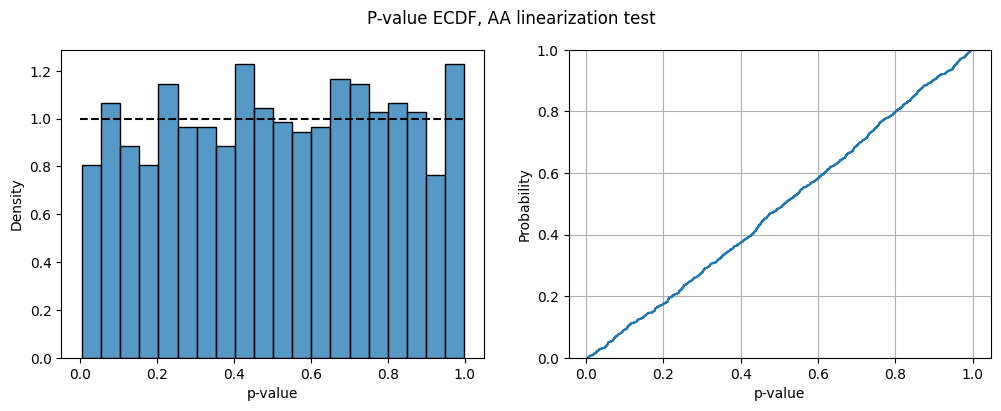

In [489]:
plot_pvalue_ecdf(pvalue_list, title='P-value ECDF, AA linearization test')

In [490]:
round(stats.kstest(pvalue_list, 'uniform', args=(0, 1)).pvalue, 3)

0.298

In [477]:
np.mean([p < 0.05 for p in pvalue_list])

0.038

Заметим что сэмплирую я без замещения. А че так, бутстрап жи сила?

Что было сначала, когда я по привычке сэмплировал с юзеров с замещением: 

*"Опа ну чего-то оно не сильно равномерное. пу пу пу"*

В общем-то изначальное интуитивное чувство, что как-то неправильно в случае линеаризации юзеров с повторением брать усилилось, чет мы опять тогда к зависимостям в данных приходим. От чего в общем-то и пытаемся уйти, используя поюзерные метрики, лол 

Я не уверен в моменте, что адекватно соображаю, поэтому проверим на всякий случай гкхм гипотезу 
Сгенерим два абсолютно одинаковых по параметрам распределения и построим распр pvalue для их теста

In [529]:
def get_session_duration(size, effect=0, seed=None):
    def _user_sessions(mean):
        size = np.random.randint(3,10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    return [_user_sessions(mean) for mean in mean_durations]

In [491]:
pvalue_check_with_replace, _ = run_bs_lin_test(
    pd.Series(get_session_duration(2000)), pd.Series(get_session_duration(2000)), N_ITER=2000,
    replace=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 126.16it/s]


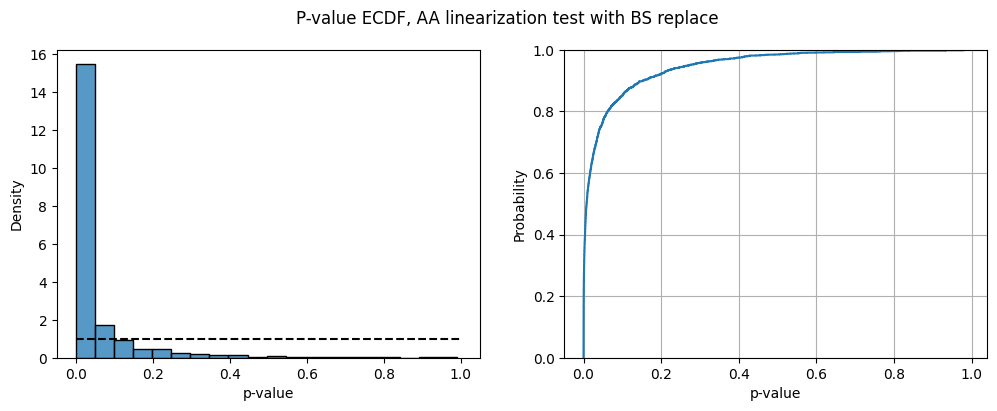

In [492]:
plot_pvalue_ecdf(pvalue_check_with_replace, title='P-value ECDF, AA linearization test with BS replace')

In [493]:
round(stats.kstest(pvalue_check_with_replace, 'uniform', args=(0, 1)).pvalue, 3)

0.0

In [504]:
pvalue_check_without_replace, _ = run_bs_lin_test(
    pd.Series(get_session_duration(2000)), pd.Series(get_session_duration(2000)), N_ITER=1000,
    replace=False, size=300
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 529.97it/s]


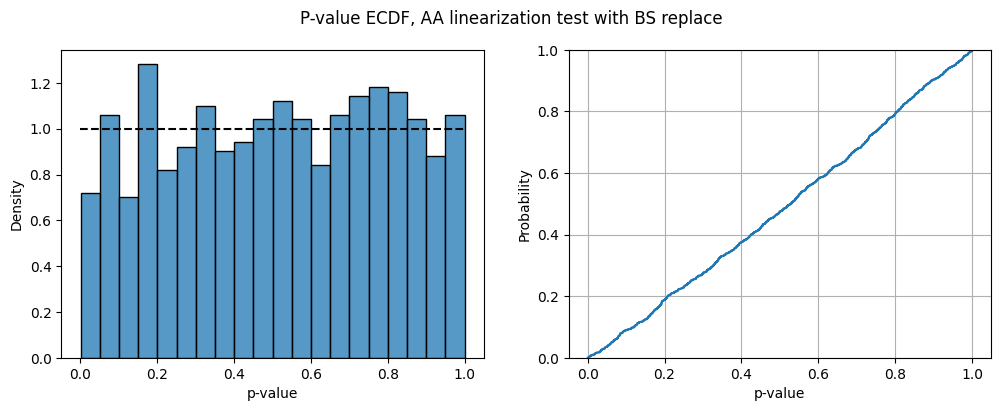

In [505]:
plot_pvalue_ecdf(pvalue_check_without_replace, title='P-value ECDF, AA linearization test with BS replace')

In [507]:
round(stats.kstest(pvalue_check_without_replace, 'uniform', args=(0, 1)).pvalue, 3)

0.237

Ага, ну вот, кажется довольно наглядно получилось, так что использую сэмплирование без замещения

**Сонаправленность**

In [464]:
(pd_eff['eff'].round(3) == pd_eff['lin_eff'].round(3)).mean()

1.0

Ну тут визуализировать нечего, но раз сказано

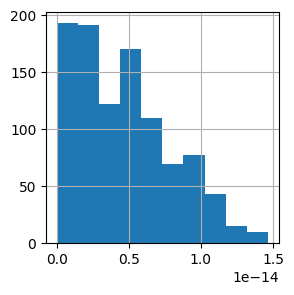

In [468]:
((pd_eff['eff'] - pd_eff['lin_eff'])).abs().hist(figsize=(3, 3));

In [515]:
# pvalue_list_2, pd_eff_2 = run_bs_lin_test(agg_d_aa['first'], agg_d_aa['second'], 10000,replace=True)

In [516]:
# plot_pvalue_ecdf(pvalue_list_2, title='P-value ECDF, AA linearization test')

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

In [306]:
d_ab = pd.read_csv('duration_ab.csv').drop('Unnamed: 0', axis=1)

In [517]:
d_ab_agg = d_ab.groupby(['group', 'user_id']).visit_duration.apply(list)

In [530]:
print(f"pvalue = {check_linearization(d_ab_agg['a'], d_ab_agg['b'])[0]:.2f}")

pvalue = 0.06


In [526]:
pvalue_list_ab, pd_eff_ab = run_bs_lin_test(d_ab_agg['a'], d_ab_agg['b'], 2000, size=200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 609.20it/s]


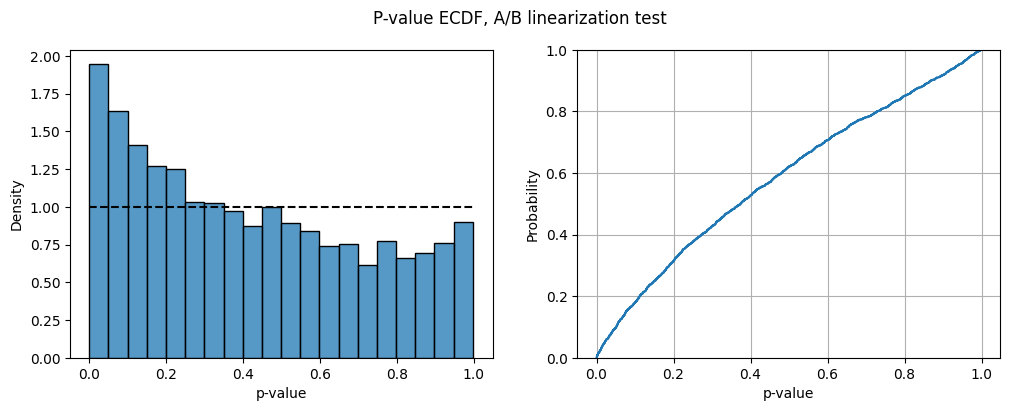

In [527]:
plot_pvalue_ecdf(pvalue_list_ab, title='P-value ECDF, A/B linearization test')

In [535]:
# ну они ж линейно выводятся друг из друга, чего визуализировать то
(pd_eff_ab.eff - pd_eff_ab.lin_eff).abs().max()

1.4654943925052066e-14

Text(0.5, 1.0, 'сонаправленность')

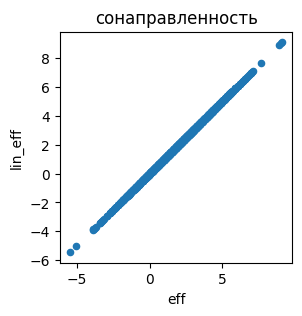

In [536]:
pd_eff_ab.plot.scatter('eff', 'lin_eff', figsize=(3, 3));
plt.title('сонаправленность')

In [537]:
round(stats.kstest(pvalue_list_ab, 'uniform', args=(0, 1)).pvalue, 3)

0.0

В общем-то некоторая разница в средних наблюдается, распределение pvalue однозначно неравномерное,  одноразовый тест с лин. на уровне значимости 0.95 нулевую гипотезу не отверг бы

Так что в целом не супер результаты (но иначе зачем бы купед в 3 пункте был)


3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

Чтобы купедироваться, нужн посчитать какую-то поюзерную метрику на прошлых данных

Можно теоретически и линеаризованную, а можно например среднее, главное чтобы коррелировало

In [539]:
history = pd.read_csv('duration_hist.csv').drop('Unnamed: 0', axis=1)

In [554]:
history.user_id.nunique()

2000

У нас по всей видимости есть данные только по юзерам из групп, значит матожидание так же будем считать на группах

Наверное очевидный факто, но пишу для себя: если мы смотрим на отклонение метрики в эксперименте по отношению к контролю, то коэф для линеаризации нужно для до/после считать отдельно 

In [693]:
# def check_cuped_linearization(a, b, a_before, b_before):
#     """Проверка гипотезы с помощью линеаризации.
    
#     a: List[np.array], список множеств длин сессий пользователей контрольной группы
#     b: List[np.array], список множеств длин сессий пользователей пилотной группы

#     a_before List[np.array], список множеств длин сессий пользователей контрольной группы до эксп
#     b_before: List[np.array], список множеств длин сессий пользователей пилотной группы до эксп

#     **должны быть отсортированы в одном порядке**
    
#     return: pvalue и точечную оценку.
#     """
#     a_x = np.array([np.sum(row) for row in a])
#     a_y = np.array([len(row) for row in a])
#     b_x = np.array([np.sum(row) for row in b])
#     b_y = np.array([len(row) for row in b])

#     a_x_before = np.array([np.sum(row) for row in a_before])
#     a_y_before = np.array([len(row) for row in a_before])
#     b_x_before = np.array([np.sum(row) for row in b_before])
#     b_y_before = np.array([len(row) for row in b_before])
    
#     coef = np.sum(a_x) / np.sum(a_y)
#     a_lin = a_x - coef * a_y
#     b_lin = b_x - coef * b_y

#     coef_before = np.sum(a_x_before) / np.sum(a_y_before)
#     a_lin_before = a_x_before - coef_before * a_y_before
#     b_lin_before = b_x_before - coef_before * b_y_before

#     theta = calc_theta(a_lin, b_lin, a_lin_before, b_lin_before)

#     mu = np.hstack([a_lin, b_lin, a_lin_before, b_lin_before]).mean()

#     a_lin_cuped = a_lin - theta * a_lin_before + theta * mu
#     b_lin_cuped = b_lin - theta * b_lin_before + theta * mu
    
#     _, pvalue = stats.ttest_ind(a_lin_cuped, b_lin_cuped)
#     delta = np.mean(b_lin_cuped) - np.mean(a_lin_cuped)

#     # для эффекта по формуле с лекции, god bless записи и гит с презами
#     Y_T = np.sum(b_lin_cuped) / len(b_lin_cuped)
    
#     return pvalue, delta / Y_T # effect

#     # return a_lin, b_lin,  a_lin_before, b_lin_before

In [759]:
def check_cuped_linearization(a, b, a_before, b_before):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы

    a_before np.array, метрика пользователей контрольной группы до эксп
    b_before: List[np.array], метрика пользователей пилотной группы до эксп

    **должны быть отсортированы в одном порядке**
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y

    theta = calc_theta(a_lin, b_lin, a_before, b_before)

    mu = np.hstack([a_before, b_before]).mean()

    a_lin_cuped = a_lin - theta * a_before + theta * mu
    b_lin_cuped = b_lin - theta * b_before + theta * mu
    
    _, pvalue = stats.ttest_ind(a_lin_cuped, b_lin_cuped)
    delta = np.mean(b_lin_cuped) - np.mean(a_lin_cuped)

    # для эффекта по формуле с лекции, god bless записи и гит с презами
    Y_T = np.sum(b_lin_cuped) / len(b_lin_cuped)
    
    return pvalue, delta / Y_T # effect

    # return a_lin, b_lin,  a_lin_before, b_lin_before, theta

In [559]:
hist_agg = history.groupby('user_id').visit_duration.apply(list)

In [735]:
theta

-0.014783827147480692

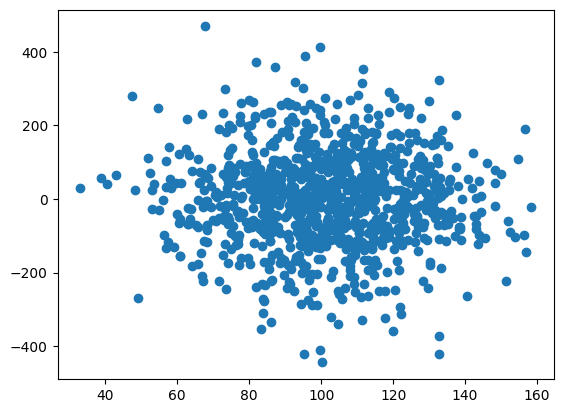

In [756]:
plt.scatter(hist_agg[d_ab_agg['a'].index].apply(np.mean), a_lin_cuped,);

In [748]:
func_list = [np.mean, np.size, np.std, np.median, np.max, np.min]

print(f"Original std: {np.std(a_lin):.2f}, {np.std(b_lin):.2f}")

for func in func_list:
    theta = calc_theta(
        a_lin,
        b_lin,
        hist_agg[d_ab_agg['a'].index].apply(func),
        hist_agg[d_ab_agg['b'].index].apply(func),
    )
    
    a_lin_cuped = a_lin - theta * hist_agg[d_ab_agg['a'].index].apply(func) + theta * hist_agg.apply(func).mean()
    b_lin_cuped = b_lin - theta * hist_agg[d_ab_agg['b'].index].apply(func) + theta * hist_agg.apply(func).mean()
    
    print(f"Cuped std: {np.std(a_lin_cuped):.2f}, {np.std(b_lin_cuped):.2f}, {func}, theta {theta:.2f}")

Original std: 128.07, 128.17
Cuped std: 127.99, 128.21, <function mean at 0x10360fac0>, theta -0.12
Cuped std: 128.05, 128.19, <function size at 0x10360f7f0>, theta -0.42
Cuped std: 128.06, 128.17, <function std at 0x10360fbe0>, theta 0.48
Cuped std: 127.98, 128.20, <function median at 0x103bca050>, theta -0.13
Cuped std: 128.00, 128.20, <function max at 0x10360f1c0>, theta -0.10
Cuped std: 127.99, 128.21, <function min at 0x10360f2e0>, theta -0.12


In [762]:
lin_cuped_pvalue, lin_cup_eff = check_cuped_linearization(
    a=d_ab_agg['a'].to_numpy(),
    b=d_ab_agg['b'].to_numpy(),
    a_before=hist_agg.apply(np.mean)[d_ab_agg['a'].index].to_numpy(),
    b_before=hist_agg.apply(np.mean)[d_ab_agg['b'].index].to_numpy(),
)

In [763]:
print(f"pvalue {lin_cuped_pvalue:.3}, lin_cup_eff: {lin_cup_eff:.3f}")

pvalue 0.0597, lin_cup_eff: 0.995


In [764]:
(d_ab_agg['b'].explode().mean() - d_ab_agg['a'].explode().mean())

1.830525216189912

In [765]:
def run_bs_lin_cuped_test(a: pd.Series, b: pd.Series, N_ITER=1000,
                          replace=False, size=100, history_=hist_agg):

    pvalue_list = []
    effect_list = []
    effect_lin_list = []

    for _ in tqdm(range(N_ITER)):
        n_a = a.shape[0]
        n_b = b.shape[0]
    
        bs_a = np.random.choice(a.index, size=n_a if replace else size, replace=replace)
        bs_b = np.random.choice(b.index, size=n_b if replace else size, replace=replace)

        lin_cuped_pvalue, lin_cup_eff = check_cuped_linearization(
            a=a[bs_a].to_numpy(),
            b=b[bs_b].to_numpy(),
            a_before=hist_agg.apply(np.mean)[bs_a].to_numpy(),
            b_before=hist_agg.apply(np.mean)[bs_b].to_numpy(),
        )
        effect = b[bs_b].explode().mean() - a[bs_a].explode().mean()
        
        pvalue_list.append(lin_cuped_pvalue)
        effect_list.append(effect)
        effect_lin_list.append(lin_cup_eff)
        
    return pvalue_list, pd.DataFrame(zip(effect_list, effect_lin_list), columns=['eff', 'lin_eff'])

In [766]:
pvalue_list_3, pd_eff_3 = run_bs_lin_cuped_test(d_ab_agg['a'], d_ab_agg['b'], 5000, size=200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:59<00:00, 84.66it/s]


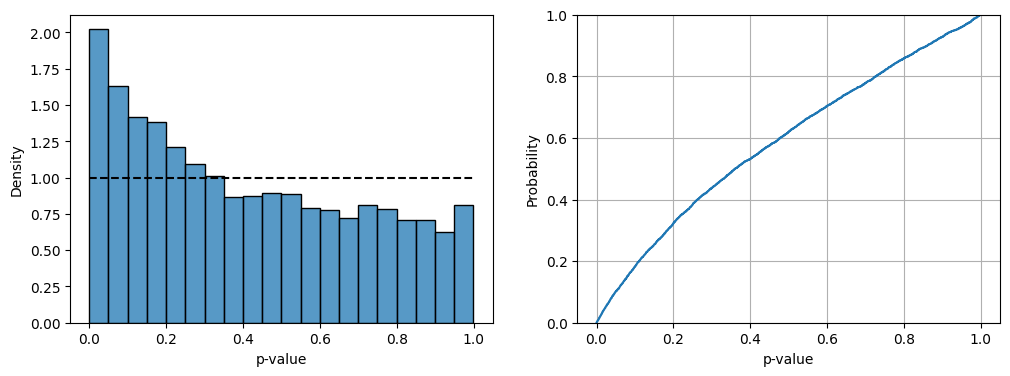

In [767]:
plot_pvalue_ecdf(pvalue_list_3)

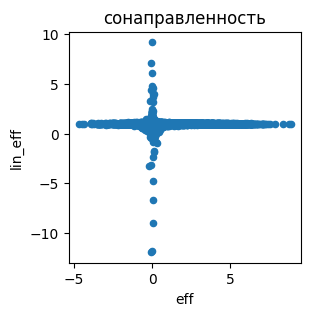

In [769]:
pd_eff_3.plot.scatter('eff', 'lin_eff', figsize=(3, 3));
plt.title('сонаправленность');

что я сделал не так?

лианеризованную историческую тоже пробовал 

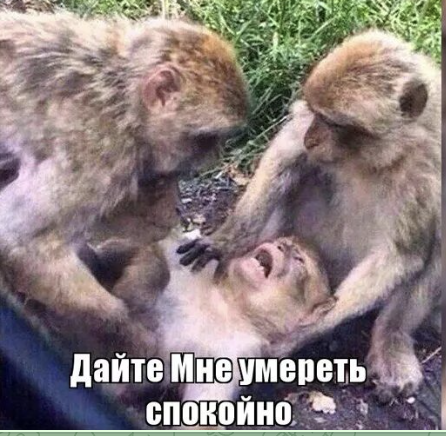

### Задача 4. Последовательное тестирование (3 балла)

Сгенерируйте две контрольные выборки и одну тестовую (с эффектом). Проведите последовательные АА-тесты и АБ-тесты по следующей схеме:

1. Попробуйте использовать t-test. Начните с 1 наблюдения в группах и последовательно добавлять по одному в каждую. Проследите, как меняется О1Р, О2Р.

2. Самостоятельно реализуйте **SPRT-тест Вальда** и проделайте ту же процедуру с ним. Что теперь происходит с О1Р и О2Р? Почему?

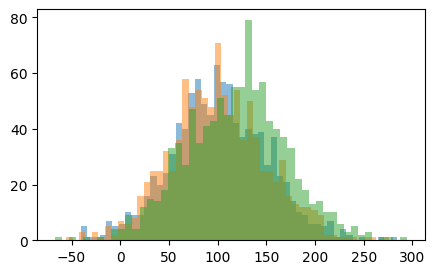

In [826]:
SAMPLE_SIZE = 1003
filter_extr = lambda x: x[(x < np.quantile(x, 0.99))]
EFFECT_MEAN = 20

plt.figure(figsize=(5, 3));

# a_syn = filter_extr(np.random.lognormal(7, 1, SAMPLE_SIZE) + np.random.normal(0, 2, SAMPLE_SIZE))
# b_syn = filter_extr(np.random.lognormal(7, 1, SAMPLE_SIZE) + np.random.normal(100, 100, SAMPLE_SIZE))

a_syn = np.random.normal(100, 49, SAMPLE_SIZE)
a_syn_2 = np.random.normal(100, 49, SAMPLE_SIZE)
b_syn = np.random.normal(100, 49, SAMPLE_SIZE) + EFFECT_MEAN

plt.hist(a_syn, bins=50, alpha=0.5);
plt.hist(a_syn_2, bins=50, alpha=0.5);
plt.hist(b_syn, bins=50, alpha=0.5);

In [820]:
AA_test_pvalue = []
AB_test_pvalue = []

NUM_OBS = np.arange(2, stop=SAMPLE_SIZE, step=1)
BS_ITER = 500

In [808]:
def bs_ttest(a, b, replace=True, size=1, N_ITER=500):

    n_a = len(a)
    n_b = len(b)
    p_value_list = [0]*N_ITER
    
    for i in range(N_ITER):
        bs_a = np.random.choice(a, size=n_a if replace else size, replace=replace)
        bs_b = np.random.choice(b, size=n_b if replace else size, replace=replace)

        p_value_list[i] = stats.ttest_ind(bs_a, bs_b)[1]

    return p_value_list

In [813]:
# bs_ttest([1, 3], [1, 2], N_ITER=10)

In [817]:
def run_subsample_bs_ttest(a, a2, b, replace=True, size=1, num_obs=NUM_OBS, n_iter=500, alpha=0.05):

    FT = []
    ST = []

    for N in tqdm(num_obs):
        
        aa_p_value_list =  bs_ttest(a[:N], a2[:N], replace, size, n_iter)
        ab_p_value_list =  bs_ttest(a[:N], b[:N], replace, size, n_iter)
        
        FT.append((np.array(aa_p_value_list) < alpha).mean())
        ST.append((np.array(ab_p_value_list) > alpha).mean())

    return FT, ST
        

In [821]:
first_type_list, second_type_list = run_subsample_bs_ttest(
    a_syn, a_syn_2, b_syn,
)

  0%|                                                                                                                                          | 0/1001 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [03:20<00:00,  5.00it/s]


In [823]:
pd_simple = pd.DataFrame(
    {
        'NUM_OBS': NUM_OBS,
        'FT': first_type_list,
        'ST': second_type_list,
    }
)

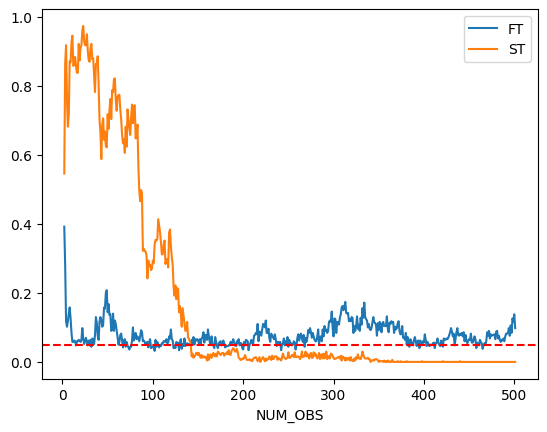

In [902]:
pd_simple.set_index('NUM_OBS').iloc[:500].plot();
plt.axhline(y=0.05, color='r', linestyle='--');

Взял большой эффект, поэтому ошибку второго рода прибило совсем в какой-то момент 

А АА группы совсем похожие получилось в тек версии, поэтому и О1Р очень быстро упала. Колебания О1Р на большем кол-ве наблюдений (после 500) связываю с маленьким количеством итераций в бутстрапе (но иначе час придется ждать расчетов) 

В любом случае, видим скачки в ошибке 1 рода, и, если подглядывать слишком рано в тест, то вполне можно сделать неверные выводы

**2.** насколько мне хватает мозгов сейчас понять, мы можем ранить sprt только для конкретной случайной величины, подставляя в правдоподобие ее параметры

Так как у нас две выборки, то в качестве случайно величины надо брать T статистику (ну или еще какую статистику если хочется). Мы можем делать два Т-теста с разными нулевыми гипотезами (т. е. mu_diff = 0, mu_diff = EFFECT) и забирать из них вероятности попадания в соответствующее теор распределение

(Получается что для нас новое наблюдение - это тест для всех уже полученных + 1, а функция плотности для формулы отношения правдоподобия - теор распределение статистики при верной H_0)

Считаем их отношения, сравниваем итеративно с порогами

Нулевой гипотезой самого SPRT считаем mu_diff = 0

Прим. Для нормального распределения кажется можем считать правдоподобие прямо по сумме каждого наблюдения, тк сумма нормальных независимых будет нормальным распределением, и останется только плотности для разных параметров посчитать 

Но этот подход не годится для других распределений (нужно считать свертку) или неизвестных распределений 

In [850]:
def ttest_for_difference(a, b, null_diff=0):

    n1, n2 = a.shape[0], b.shape[0]
    s1, s2 = a.std(), b.std()
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    d_f = s**4 / ((s1**2/n1)**2/(n1 - 1) + (s2**2/n2)**2/(n2 - 1))
    T_obs = (a.mean() - b.mean() - null_diff) / s
    
    # p_value = min(2 * t.cdf(T_obs, d_f), 2 * (1 - t.cdf(T_obs, d_f)))

    probability = stats.t.pdf(T_obs, df=d_f)
    
    return probability

In [856]:
# так, ну вроде ПрАвДоПоДоБнО

ttest_for_difference(a_syn, b_syn, null_diff=-EFFECT_MEAN), ttest_for_difference(a_syn, b_syn, null_diff=0)

(0.1677519628488763, 1.8342420344661735e-13)

Делить на совсем маленькие значения не хочется, поэтому перейдем к логарифмам наверное, есть наитие что складывать точнее будет 

In [861]:
def calculate_log_lr(a, b, null_diff=0, alternative_diff=-EFFECT_MEAN):
    return (
        np.log(ttest_for_difference(a, b, alternative_diff)) - 
        np.log(ttest_for_difference(a, b, null_diff))
    )

In [862]:
calculate_log_lr(a_syn, b_syn,)

27.541706070823075

Эффект большой, АА выборки очень похожи, поэтому смело ставим очень маленькие alpha & beta

In [897]:
def run_sprt(a, b, alpha=0.00005, beta=0.000005, num_obs=NUM_OBS, null_diff=0, alternative_diff=-EFFECT_MEAN):

    log_lr_sum = 0
    decision = None

    gamma_0 = np.log(beta / (1 - alpha))
    gamma_1 = np.log((1 - beta) / alpha)

    for N in tqdm(num_obs):
        log_lr = calculate_log_lr(a[:N], b[:N], null_diff, alternative_diff)

        if log_lr <= gamma_0:
            decision = 0
            break
        elif log_lr >= gamma_1:
            decision = 1
            break
            
    return decision, N, log_lr

In [898]:
run_sprt(a_syn, a_syn_2)

 19%|███████████████████████▍                                                                                                      | 186/1001 [00:00<00:00, 2148.60it/s]


(0, 188, -12.281710551601147)

In [903]:
run_sprt(a_syn, b_syn)

 23%|████████████████████████████▌                                                                                                 | 227/1001 [00:00<00:00, 2389.62it/s]


(1, 229, 10.029936294638922)

Точечные раны дают на АА и АБ тестах прокрас примерно когда стабилизировались О1Р и О2Р в изначальном тесте

То есть задача в целом выполнена, мы дали результат примерно на том же кол-ве 

Проверим О1Р и О2Р

In [904]:
def run_sprt_without_tqdm(a, b, alpha=0.00005, beta=0.000005,
                          num_obs=NUM_OBS, null_diff=0, alternative_diff=-EFFECT_MEAN):

    log_lr_sum = 0
    decision = None

    gamma_0 = np.log(beta / (1 - alpha))
    gamma_1 = np.log((1 - beta) / alpha)

    for N in num_obs:
        log_lr = calculate_log_lr(a[:N], b[:N], null_diff, alternative_diff)

        if log_lr <= gamma_0:
            decision = 0
            break
        elif log_lr >= gamma_1:
            decision = 1
            break
            
    return decision, N, log_lr

In [910]:
W_N_ITER = 500
idx = np.arange(1, SAMPLE_SIZE)
W_FT = 0
W_ST = 0

for i in tqdm(range(W_N_ITER)):
    
    np.random.shuffle(idx)
    a_i = a_syn[idx]
    np.random.shuffle(idx)
    a_2_i = a_syn_2[idx]
    b_i = b_syn[idx]

    # отвергаем верную h0
    W_FT += int(run_sprt_without_tqdm(a_i, a_2_i)[0] == 1)

    # принимаем неверную h0
    W_ST += int(run_sprt_without_tqdm(a_i, b_i)[0] == 0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.88it/s]


In [911]:
W_FT / W_N_ITER

0.0

In [912]:
W_ST / W_N_ITER

0.0

Ну здесь мы ожидаемо уперлись в 0, тк эффект большой, а заданные параметры для О 1 и 2 рода очень малы 

Вывод: товарищи! если хотите пораньше закончить тест, используйте sprt, а не просто смотрите на ПИВАлью

### Задача 5. Бонус от лектора (5 баллов)

_3 балла за выполнение __всех__ пунктов 1-5. +2 балла за пункт 6, при условии, что пункты 1-5 выполнены._

1. Реализуйте mSPRT, предполагая, что функция правдободобия имеет нормальное распределение 
2. Выведите теоретический вид статистики $\Lambda_n$ для нормального распределения 
3. Постройте распределение времени остановки для mSPRT и распределение p-value на А/А тесте 
4. Сделайте то же самое, но для синтетического А/В (добавьте искуственно эффект). Опишите, что поменялось 
5. Сравните mSPRT с классическим t-test
6. Замените расчет интеграла  $\Lambda_n$ на численное приближение расчета. Сравните результаты по пункту 3 и 4